In [ ]:
import cv2
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import albumentations as A

from random import Random
from torch.utils.data import Dataset
from glob import glob
from typing import Any, Dict, List
from matplotlib.path import Path
from typing import Dict, Any, List
from torch.utils.data import DataLoader, random_split
from torch import optim
from tqdm.auto import tqdm
from sklearn.metrics import jaccard_score, accuracy_score
from typing import Any, Dict, List
from pathlib import Path

# Задача 8. Компьютерное зрение: задача сегментации

## Задача

Обучаем Сегментацию:
- https://colab.research.google.com/drive/1eUIOnLFB_9_6CJ3dVZxY9TV_gCqDAmaV?authuser=1#scrollTo=SjKfL5X_RbzH --- тут мы обучали на большом датасете одну эпоху.
- https://drive.google.com/file/d/11wp4Bm-hEVwmZq8GmqbLpKpJiqvDSNAe/view?usp=sharing --- тут лежит датасет который мы будем использовать.

Мы хотим обучить наш unet на небольшом датасете. Нужно заполнить репорт и сделать выводы.
Чтобы успеть сделать много экспериментов нужна видеокарта. Можно использовать colab, тут есть бесплатные gpu ресурсы --- так будет быстрее.


- [x] Сделать train/test split (или кросс-валидацию), зафиксировать все сиды чтобы более-менее воспроизводились результаты. Добавить метрику **jaccard index**. Переобучиться на одном батче (например 4 картинки), попробовать получить почти идеальное качество, посмотреть получилось или нет. Посчитать метрики для батча и для теста. Обучить на всем train, построить train/val кривые для loss и для **jaccard index**, подобрать оптимальное время обучения (количество шагов) для фиксированных параметров. Визуализировать topN самых плохих предсказаний.
- [x] Попробовать улучшить качество не меняя архитектуру: аугментации, гиперпараметры. Сделать test time аугментации через horizontal flip, посмотреть улучшается ли что-то.
- [x] Попробовать улучшить качество изменяя архитектуру.
- [x] (**+2 балла**) Сделать train/test разбиение. Внутри train сделать 5fold, обучить 5 моделей. Построить кривые обучения для каждого фолда. Предсказать тест со всех 5 моделей и сагрегировать предсказания (до расчета метрик), сравнить с одной моделью обученной на всех данных. Сравнить с моделями обученными на фолдах. Сравнить плохие предсказания теста на разных фолдах. Ошибается на одних и тех же семплах или на разных?

# Константы

In [ ]:
DATASET = "./dataset"
RANDOM_SEED = 666
DATA_SUBSET_SIZE = 100
TRAIN_RATIO = 0.8
BATCH_SIZE = 32
NUM_WORKERS = 2

In [4]:
class CastomDataset(Dataset):
    def __init__(self, dataset_path: str, transform = None):
        self.image_paths = (glob(str(Path(dataset_path)/"images"/"*.jpg")))
        self.mask_paths = (glob(str(Path(dataset_path)/"masks"/"*.png")))
        self.transform = transform
        self.target_size = (256, 256)

    def __len__(self) -> int:
        return len(self.image_paths)

    def __getitem__(self, idx) -> Dict[str, Any] | List[Dict[str, Any]]:
        if isinstance(idx, slice):
            return [self[i] for i in range(*idx.indices(len(self)))]
        
        image = self._load_image(self.image_paths[idx])
        mask = self._load_mask(self.mask_paths[idx])
        
        if self.transform:
            augmented = self.transform(
                image=image.astype(np.float32),
                mask=mask.astype(np.uint8)
            )
            image, mask = augmented['image'], augmented['mask']

        return {
            "image": torch.tensor(image.transpose(2, 0, 1)), 
            "mask": torch.tensor(mask, dtype=torch.long)[None, ...]
        }

    def _load_image(self, path: str) -> np.ndarray:
        image = cv2.imread(path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return (cv2.resize(image, self.target_size) / 255.0).astype(np.float32)

    def _load_mask(self, path: str) -> np.ndarray:
        mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, self.target_size) > 100
        return mask.astype(np.uint8)

фиксация сида (чтою можно было воспроизвести результаты)

In [ ]:
train_size = int(TRAIN_RATIO * DATA_SUBSET_SIZE)
test_size = DATA_SUBSET_SIZE - train_size

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

# Датасет

Был взят предложенный в условии датасет. Он был вручную установлен по пути представленном в `DATASET`.

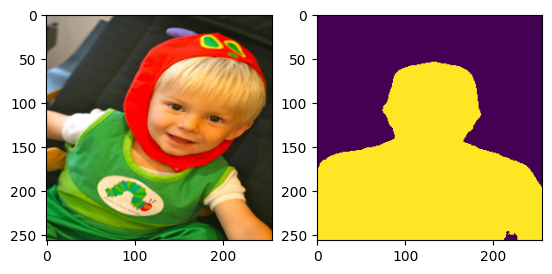

In [44]:
data = CastomDataset(DATASET)
_, axarr = plt.subplots(1,2)
axarr[0].imshow(data[13]["image"].permute(1, 2, 0))
axarr[1].imshow(data[13]["mask"].permute(1, 2, 0))

plt.show()

# Построение U-NET (как в примере)

In [7]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0):
        super(CNNBlock, self).__init__()
        self.seq_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.seq_block(x)

class CNNBlocks(nn.Module):
    def __init__(self, n_conv, in_channels, out_channels, padding):
        super(CNNBlocks, self).__init__()
        self.layers = nn.ModuleList()
        for _ in range(n_conv):
            self.layers.append(CNNBlock(in_channels, out_channels, padding=padding))
            in_channels = out_channels

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels, padding, n_down=4):
        super(Encoder, self).__init__()
        self.enc_layers = nn.ModuleList()
        for _ in range(n_down):
            self.enc_layers.extend([
                CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding),
                nn.MaxPool2d(2, 2)
            ])
            in_channels = out_channels
            out_channels *= 2

        self.enc_layers.append(CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding))

    def forward(self, x):
        connections = []
        for layer in self.enc_layers:
            x = layer(x)
            if isinstance(layer, CNNBlocks):
                connections.append(x)

        return x, connections

class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels, exit_channels, padding, n_up=4):
        super(Decoder, self).__init__()
        self.exit_channels = exit_channels
        self.layers = nn.ModuleList()

        for _ in range(n_up):
            self.layers.extend([
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding)
            ])
            in_channels //= 2
            out_channels //= 2

        self.layers.append(nn.Conv2d(in_channels, self.exit_channels, kernel_size=1, padding=0))

    def forward(self, x, connections):
        connections.pop(-1)
        for layer in self.layers:
            if isinstance(layer, CNNBlocks):
                connections_current = connections.pop(-1)
                dim_4 = connections_current.size(3) - x.size(3)
                dim_3 = connections_current.size(2) - x.size(2)
                if dim_4 != 0 or dim_3 != 0:
                    x = nn.functional.pad(x, [0, dim_4, 0, dim_3])
                x = torch.cat([x, connections_current], dim=1)

            x = layer(x)
        return x

class UNET(nn.Module):
    def __init__(self, in_channels, first_out_channels, exit_channels, n_down=4, padding=1):
        super(UNET, self).__init__()
        self.encoder = Encoder(in_channels, first_out_channels, padding=padding, n_down=n_down)
        self.decoder = Decoder(first_out_channels * (2 ** n_down),
                               first_out_channels * (2 ** (n_down - 1)),
                               exit_channels, padding=padding, n_up=n_down)

    def forward(self, x):
        enc_out, connections = self.encoder(x)
        return self.decoder(enc_out, connections)

# Разделение датасета

In [45]:
dataset_subset = data[:DATA_SUBSET_SIZE]

train_data, test_data = random_split(
    dataset_subset,
    [train_size, test_size],
    generator=torch.Generator().manual_seed(RANDOM_SEED)
)

loader_config = {
    'batch_size': BATCH_SIZE,
    'num_workers': NUM_WORKERS,
    'pin_memory': True
}

train_loader = DataLoader(
        train_data, 
        shuffle=True, 
        batch_size=BATCH_SIZE, 
        num_workers=NUM_WORKERS, 
        pin_memory=True
    )
test_loader = DataLoader(
        test_data, shuffle=False, 
        batch_size=BATCH_SIZE, 
        num_workers=NUM_WORKERS, 
        pin_memory=True
    ) 

# Упрощенное обучение на части датасета

In [ ]:
net = UNET(3, 16, 1)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=3e-4)

net = net.cuda().float()

torch.cuda.empty_cache()

for epoch in tqdm(range(10)):
    for i, data in enumerate(train_loader, 0):
        x = data['image']
        y = data['mask']

        optimizer.zero_grad()
        outputs = net(x.cuda().float())

        loss = criterion(outputs, y.cuda().float())
        loss.backward()
        optimizer.step()

100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


In [ ]:
def accuracy(net, loader):
    net.eval()

    with torch.no_grad():
        for data in loader:
              x = data['image'].cuda().float()
              y = data['mask'].cuda().float()

              preds = net(x)
              preds = (preds > 0.5).float()

              total_score = 0.0
              count = 0

              for preds, mask in zip(preds, y):
                pred_np = preds.squeeze().detach().cpu().numpy().astype(int).flatten()
                mask_np = mask.squeeze().detach().cpu().numpy().astype(int).flatten()

                score = accuracy_score(mask_np, pred_np)
                total_score += score
                count += 1

              return total_score / count

def jaccard_index(net, loader):
    net.eval()

    with torch.no_grad():
        for data in loader:
              x = data['image'].cuda().float()
              y = data['mask'].cuda().float()

              preds = net(x)
              preds = (preds > 0.5).float()

              total_score = 0.0
              count = 0

              for preds, mask in zip(preds, y):
                pred_np = preds.squeeze().detach().cpu().numpy().astype(int).flatten()
                mask_np = mask.squeeze().detach().cpu().numpy().astype(int).flatten()

                score = jaccard_score(mask_np, pred_np, average='binary')
                total_score += score
                count += 1

              return total_score / count

def calc_loss(net, loader):
    net.eval()

    val_loss = 0.0

    with torch.no_grad():
        for val_data in loader:
            x = val_data['image'].cuda().float()
            y = val_data['mask'].cuda().float()

            preds = net(x)
            val_loss += criterion(preds, y).item()

    val_loss /= len(loader)

    return val_loss


def show_predict(net, test_loader):
    net.eval()

    with torch.no_grad():
        for data in test_loader:
              x = data['image'].cuda().float()
              y = data['mask']

              pred = net(x)

              _, axarr = plt.subplots(1, 3, figsize=(8, 4))
              axarr[0].imshow(pred[0][0].detach().cpu().numpy() > 0)
              axarr[0].set_title('Prediction')
              axarr[1].imshow(y[0][0].detach().cpu().numpy())
              axarr[1].set_title('Mask')
              axarr[2].imshow(x[0][0].detach().cpu().numpy())
              axarr[2].set_title('Image')

              for ax in axarr:
                  ax.axis('off')

              plt.tight_layout()
              plt.show()
              break

def show_worst(net, loader, n: int):
    net.eval()

    preds_list, masks_list, imgs_list, scores_list = [], [], [], []

    with torch.no_grad():
        for batch in loader:
            imgs = batch['image'].cuda().float()
            masks = batch['mask'].cuda().float()

            preds = (net(imgs) > 0.5).float()

            for pred, mask, img in zip(preds, masks, imgs):
                pred_np = pred.squeeze().cpu().numpy().astype(int).flatten()
                mask_np = mask.squeeze().cpu().numpy().astype(int).flatten()
                score = jaccard_score(mask_np, pred_np, average='binary')

                preds_list.append(pred)
                masks_list.append(mask)
                imgs_list.append(img)
                scores_list.append(score)

    worst_indices = np.argsort(scores_list)[:n]

    _, axes = plt.subplots(3, n, figsize=(3 * n, 6))

    for i, idx in enumerate(worst_indices):
        axes[0, i].imshow(preds_list[idx][0].cpu().numpy() > 0)
        axes[0, i].set_title('Prediction')

        axes[1, i].imshow(masks_list[idx][0].cpu().numpy())
        axes[1, i].set_title('Mask')

        axes[2, i].imshow(imgs_list[idx][0].cpu().numpy())
        axes[2, i].set_title('Image')

    for row in axes:
        for ax in row:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

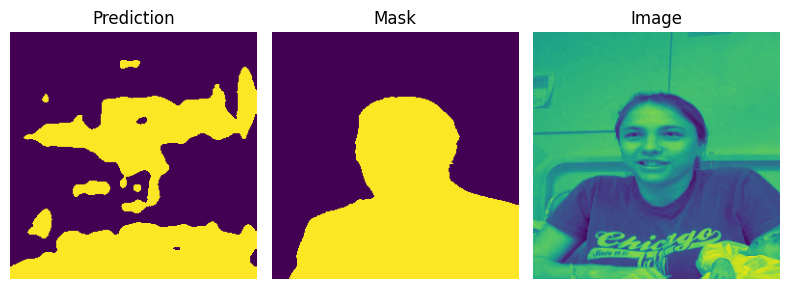

Jaccard index: 0.46202135534785216
Accuracy: 0.6610458374023438


In [ ]:
show_predict(net, test_loader)
print(f"Jaccard index: {jaccard_index(net, test_loader)}")
print(f"Accuracy: {accuracy(net, test_loader)}")

# Переобучение модели на небольшой части исходного датасета

In [ ]:
train, test = random_split(dataset_subset, [5, 95], generator=torch.Generator().manual_seed(RANDOM_SEED))
train_loader = DataLoader(
        train, 
        batch_size=8, 
        shuffle=True, 
        num_workers=2
)
test_loader = DataLoader(
        test, 
        batch_size=8, 
        shuffle=False, 
        num_workers=2
)

print(f"Train: {len(train)}\nTest: {len(test)}")

Train: 5
Test: 95


In [19]:
net = UNET(3, 16, 1)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=3e-4)

net = net.cuda()

torch.cuda.empty_cache()

accuracy_dict = {"train": [], "test": []}
jaccard_dict = {"train": [], "test": []}
loss_dict = {"train": [], "test": []}

EPOCHS = 250

for epoch in tqdm(range(EPOCHS)):
    val_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        x = data['image']
        y = data['mask']

        optimizer.zero_grad()
        outputs = net(x.cuda().float())

        loss = criterion(outputs, y.cuda().float())
        val_loss += loss.item()
        loss.backward()
        optimizer.step()

    accuracy_dict["train"].append(accuracy(net, train_loader))
    jaccard_dict["train"].append(jaccard_index(net, train_loader))
    loss_dict["train"].append(val_loss / len(train_loader))

    accuracy_dict["test"].append(accuracy(net, test_loader))
    jaccard_dict["test"].append(jaccard_index(net, test_loader))
    loss_dict["test"].append(calc_loss(net, test_loader))

100%|██████████| 250/250 [07:54<00:00,  1.90s/it]


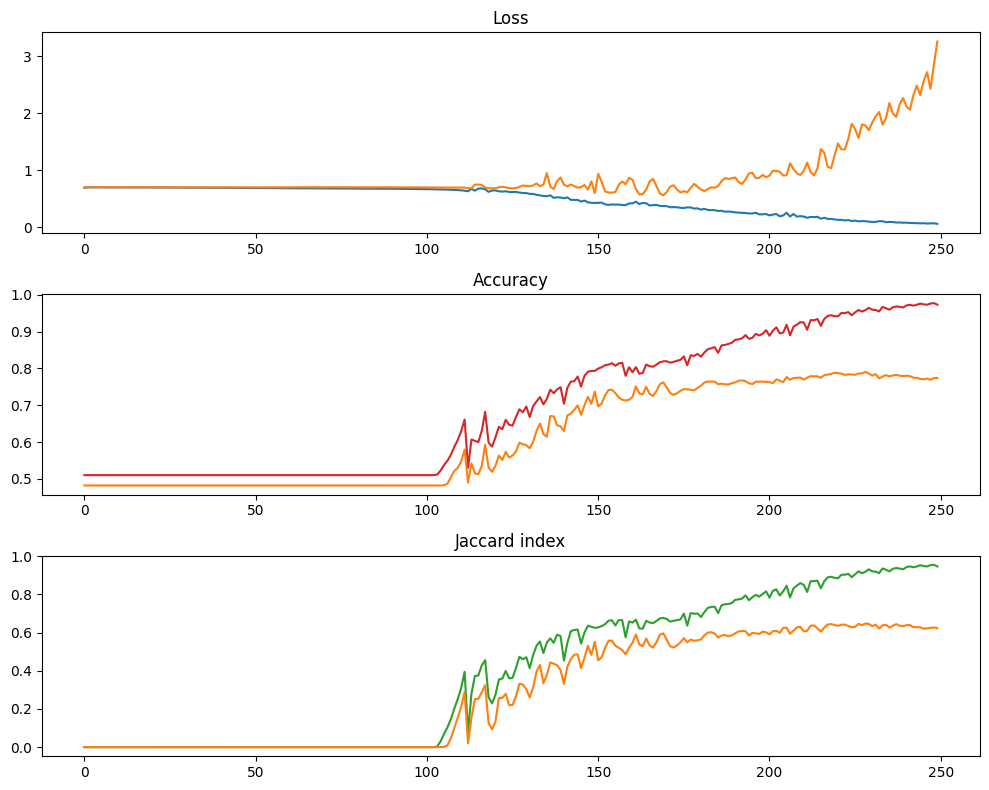

In [23]:
plt.figure(figsize=(10, 8))

plt.subplot(3,1,1)
plt.title("Loss")
plt.plot(range(EPOCHS), loss_dict["train"], color='C0')
plt.plot(range(EPOCHS), loss_dict["test"], color='C1')

plt.subplot(3,1,2)
plt.title("Accuracy")
plt.plot(range(EPOCHS), accuracy_dict["train"], color='C3')
plt.plot(range(EPOCHS), accuracy_dict["test"], color='C1')

plt.subplot(3,1,3)
plt.title("Jaccard index")
plt.plot(range(EPOCHS), jaccard_dict["train"], color='C2')
plt.plot(range(EPOCHS), jaccard_dict["test"], color='C1')

plt.tight_layout()

plt.show()

На графиках видно, что переобучить модель получилось (так как training loss падает, а validation loss увеличивается)

# TopN худших результатов

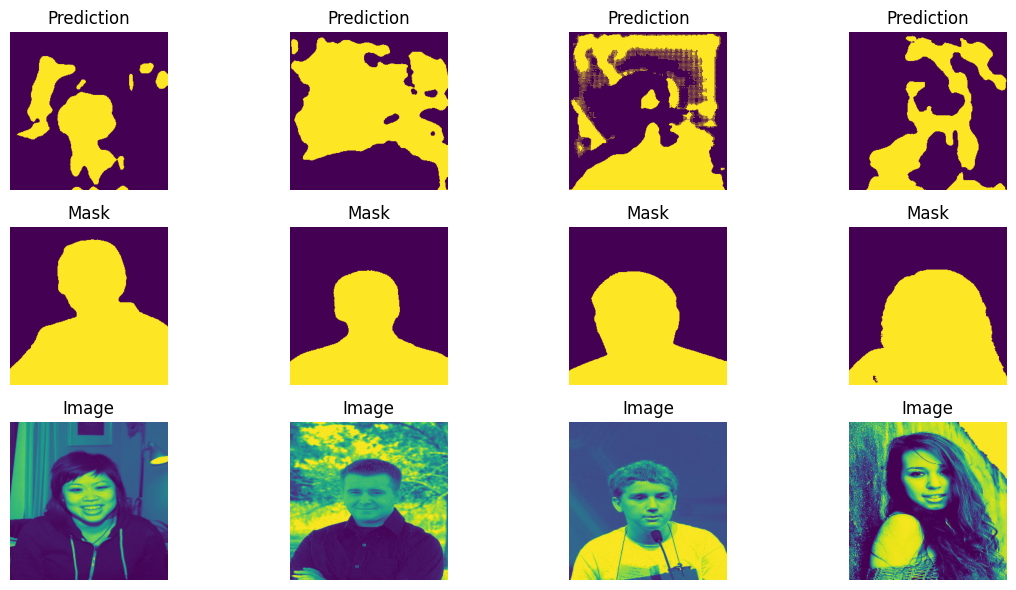

In [ ]:
show_worst(net, test_loader, 4)

# Подбор оптимального времени обучения (количество эпох)

In [27]:
jaccard_dict = {"train": [], "test": []}

EPOCHS = [1, 10, 50, 100, 200, 300]

for epochs_num in tqdm(EPOCHS):
  net = UNET(3, 16, 1)
  criterion = nn.BCEWithLogitsLoss()
  optimizer = optim.Adam(net.parameters(), lr=3e-4)

  net = net.cuda()

  torch.cuda.empty_cache()

  for epoch in range(epochs_num):
      val_loss = 0.0
      for i, data in enumerate(train_loader, 0):
          x = data['image']
          y = data['mask']

          optimizer.zero_grad()
          outputs = net(x.cuda().float())

          loss = criterion(outputs, y.cuda().float())
          val_loss += loss.item()
          loss.backward()
          optimizer.step()

  jaccard_dict["train"].append(jaccard_index(net, train_loader))
  jaccard_dict["test"].append(jaccard_index(net, test_loader))

100%|██████████| 6/6 [02:07<00:00, 21.17s/it]


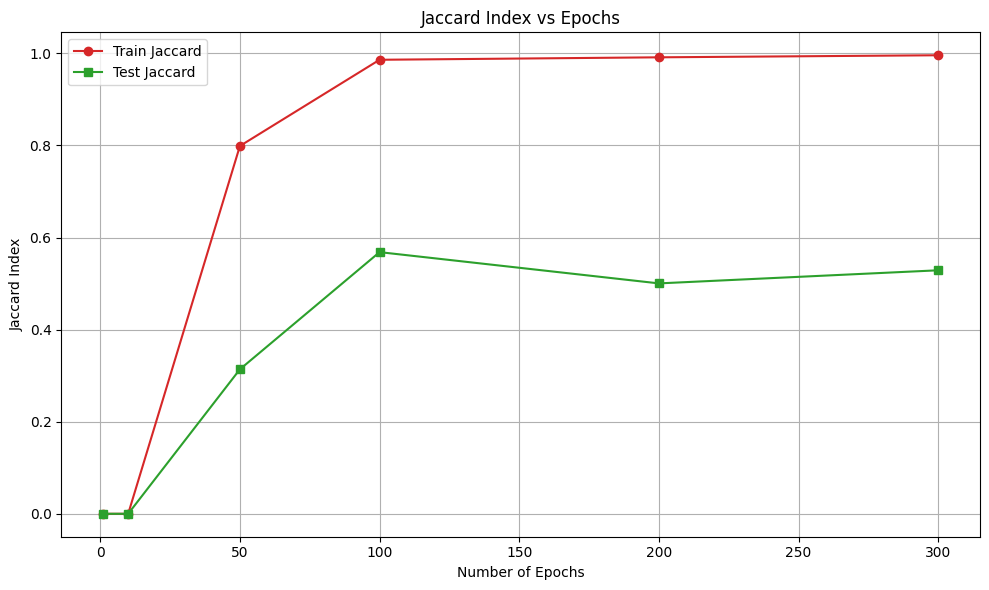

In [28]:
plt.figure(figsize=(10, 6))

plt.plot(EPOCHS, jaccard_dict["train"], label='Train Jaccard', marker='o', color="C3")
plt.plot(EPOCHS, jaccard_dict["test"], label='Test Jaccard', marker='s', color="C2")

plt.xlabel("Number of Epochs")
plt.ylabel("Jaccard Index")
plt.title("Jaccard Index vs Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Здесь видно, что оптимальное число эпох -- это от 100 эпох до 200.

# Аугментации

In [34]:
aug = A.Compose([
    A.RandomRotate90(),
    A.RandomCrop(200,200),
    A.RGBShift(r_shift_limit=100, g_shift_limit=100, b_shift_limit=100, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Resize(height=256, width=256, p=1)
])

In [35]:
aug_data = CastomDataset(DATASET, aug)[:1500]

train_dataset, test_dataset = torch.utils.data.random_split(aug_data, [1000, 500], generator=torch.Generator().manual_seed(RANDOM_SEED))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2)

Shape: torch.Size([3, 256, 256])


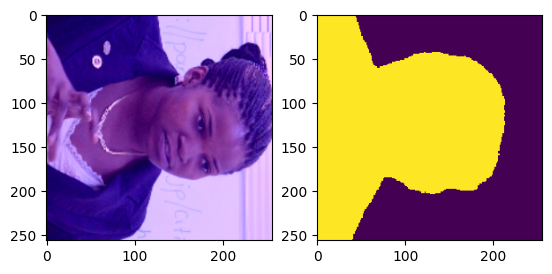

In [ ]:
_, axarr = plt.subplots(1,2)

i = Random(RANDOM_SEED).randint(0, len(aug_data)-1)

print(f"Shape: {aug_data[i]['image'].shape}")

axarr[0].imshow(aug_data[i]["image"].permute(1, 2, 0).detach().cpu().numpy())
axarr[1].imshow(aug_data[i]["mask"].permute(1, 2, 0))

plt.show()

Полноценное обучение моделей и измерение метрик:

In [ ]:
EPOCHS = 200

accuracy_dict = {"train": [], "test": []}
jaccard_dict = {"train": [], "test": []}
loss_dict = {"train": [], "test": []}

In [ ]:
net = UNET(3, 16, 1)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=3e-4)
net = net.cuda()
torch.cuda.empty_cache()

for epoch in tqdm(range(EPOCHS)):
    for i, data in enumerate(train_loader, 0):
        x = data['image']
        y = data['mask']

        optimizer.zero_grad()
        outputs = net(x.cuda().float())

        loss = criterion(outputs, y.cuda().float())
        loss.backward()
        optimizer.step()

    accuracy_dict["test"].append(accuracy(net, test_loader))
    jaccard_dict["test"].append(jaccard_index(net, test_loader))
    loss_dict["train"].append(calc_loss(net, test_loader))

100%|██████████| 200/200 [26:28<00:00,  7.94s/it]


Accuracy: 0.8041751291314496, Jaccard: 0.7654310291968993


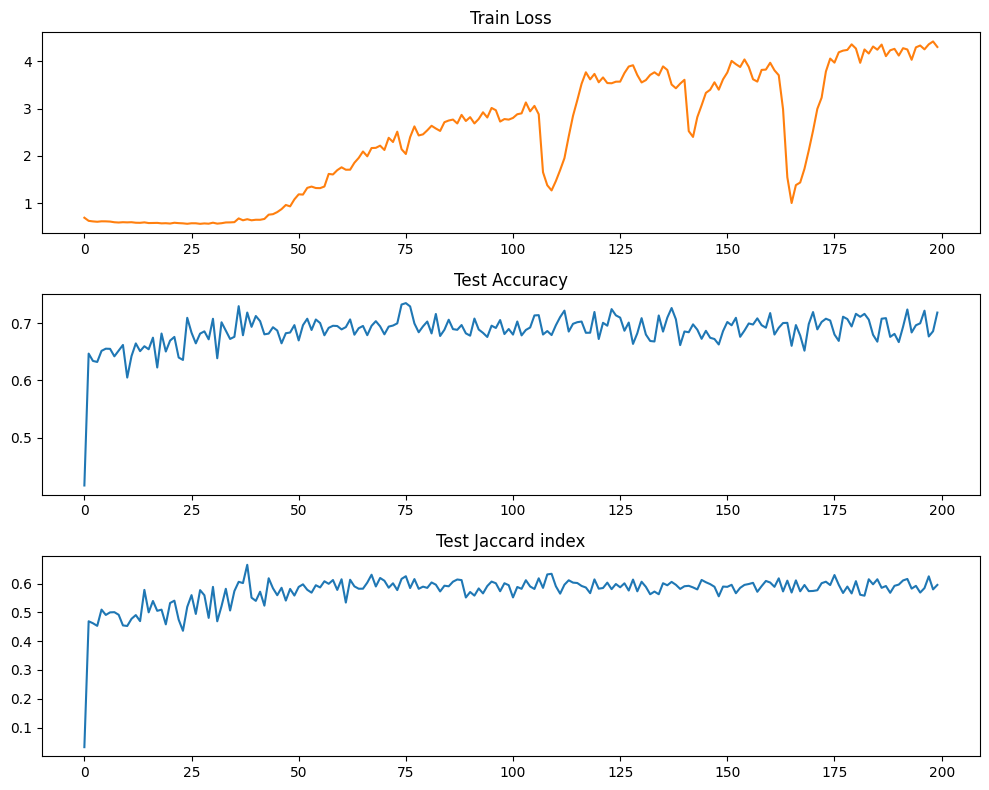

In [ ]:
print(f"Accuracy: {max(accuracy_dict['test'])}, Jaccard: {max(jaccard_dict['test'])}")

plt.figure(figsize=(10, 8))

plt.subplot(3,1,1)
plt.plot(range(EPOCHS), loss_dict["train"], color='C1')

plt.title("Train Loss")

plt.subplot(3,1,2)
plt.plot(range(EPOCHS), accuracy_dict["test"], color='C0')

plt.title("Test Accuracy")

plt.subplot(3,1,3)
plt.plot(range(EPOCHS), jaccard_dict["test"], color='C0')


plt.title("Test Jaccard index")
plt.tight_layout()

plt.show()

Таким образом с аугментацией удалось расширить датасет и улучшить паказания метрик. 

# Обновленная архитектура

- добавлена loss-функция
- relu слой в каждом блоке
- дополнительные слои в начале обучения
- dropout в каждом блоке, для предотвращения переобучения

In [ ]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(CNNBlock, self).__init__()

        self.seq_block = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.3),
            nn.Conv2d(out_channels, out_channels, kernel_size=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.seq_block(x)


class CNNBlocks(nn.Module):
    def __init__(self, n_conv, in_channels, out_channels, padding=1):
        super(CNNBlocks, self).__init__()

        self.layers = nn.ModuleList()

        for i in range(n_conv):
            self.layers.append(CNNBlock(in_channels, out_channels, padding=padding))
            in_channels = out_channels

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels, padding=1, n_down=4):
        super(Encoder, self).__init__()

        self.enc_layers = nn.ModuleList()

        for _ in range(n_down):
            self.enc_layers += [
                CNNBlocks(
                    n_conv=2,
                    in_channels=in_channels,
                    out_channels=out_channels,
                    padding=padding,
                ),
                nn.MaxPool2d(2, 2),
            ]
            in_channels = out_channels
            out_channels = 2 * out_channels

        self.enc_layers.append(
            CNNBlocks(
                n_conv=2,
                in_channels=in_channels,
                out_channels=out_channels,
                padding=padding,
            )
        )

    def forward(self, x):
        connections = []

        for layer in self.enc_layers:
            if isinstance(layer, CNNBlocks):
                x = layer(x)
                connections.append(x)
            else:
                x = layer(x)

        return x, connections


class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels, exit_channels, padding=1, n_up=4):
        super(Decoder, self).__init__()

        self.exit_channels = exit_channels
        self.layers = nn.ModuleList()

        for i in range(n_up):
            self.layers += [
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                CNNBlocks(
                    n_conv=2,
                    in_channels=in_channels,
                    out_channels=out_channels,
                    padding=padding,
                ),
            ]

            in_channels //= 2
            out_channels //= 2

        self.layers.append(
            nn.Conv2d(in_channels, self.exit_channels, kernel_size=1, padding=0)
        )

    def forward(self, x, connections):
        connections.pop(-1)
        for layer in self.layers:
            if isinstance(layer, CNNBlocks):
                connections_current = connections.pop(-1)
                x = torch.cat([x, connections_current], dim=1)
                x = layer(x)
            else:
                x = layer(x)
        return x


class UNET(nn.Module):
    def __init__(
        self, in_channels, first_out_channels, exit_channels, n_down=4, padding=1
    ):
        super(UNET, self).__init__()
        self.encoder = Encoder(
            in_channels, first_out_channels, padding=padding, n_down=n_down
        )
        self.decoder = Decoder(
            first_out_channels
            * (2**n_down),
            first_out_channels
            * (2 ** (n_down - 1)),
            exit_channels,
            padding=padding,
            n_up=n_down,
        )

    def forward(self, x):
        enc_out, connections = self.encoder(x)
        return self.decoder(enc_out, connections)

class JaccardLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(JaccardLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection

        IoU = (intersection + smooth)/(union + smooth)

        return 1 - IoU

class ComboLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super().__init__()
        self.alpha = alpha
        self.bce = nn.BCEWithLogitsLoss()
        self.jaccard = JaccardLoss()

    def forward(self, inputs, targets):
        bce = self.bce(inputs, targets)
        jaccard = self.jaccard(torch.sigmoid(inputs), targets)
        return self.alpha * bce + (1 - self.alpha) * jaccard

In [ ]:
augmentation = A.Compose([
    A.RandomRotate90(),
    A.RandomCrop(200,200),
    A.RGBShift(r_shift_limit=100, g_shift_limit=100, b_shift_limit=100, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Resize(height=256, width=256, p=1)
])

aug_data = CastomDataset(DATASET, augmentation)

train_dataset, test_dataset = random_split(aug_data, [1500, 500], generator=torch.Generator().manual_seed(RANDOM_SEED))

train_loader = DataLoader(
        train_dataset, 
        batch_size=32, 
        shuffle=True, 
        num_workers=2
    )
test_loader = torch.utils.data.DataLoader(
        test_dataset, 
        batch_size=32, 
        shuffle=True, 
        num_workers=2
    )

In [ ]:
net = UNET(3, 16, 1)
criterion = ComboLoss()
optimizer = optim.Adam(net.parameters(), lr=3e-4)
net = net.cuda()

torch.cuda.empty_cache()

EPOCHS = 200

for epoch in tqdm(range(EPOCHS)):
    for i, data in enumerate(train_loader, 0):
        x = data['image']
        y = data['mask']

        optimizer.zero_grad()
        outputs = net(x.cuda().float())

        loss = criterion(outputs, y.cuda().float())
        loss.backward()
        optimizer.step()

print(f"Result accuracy: {accuracy(net, test_loader)}")
print(f"Result jaccard index: {jaccard_index(net, test_loader)}")

100%|██████████| 200/200 [42:01<00:00, 12.61s/it]


Result accuracy: 0.8938925132751465
Result jaccard index: 0.8355160139490924


Новая архитектура показала наилучший результат: и accuracy, и jaccard index увеличились.

# K-Fold

Применим технику k-fold и сравним полученные результаты с обычным обучением.

100%|██████████| 50/50 [11:05<00:00, 13.30s/it]


Fold 0 Jaccard: 0.5947 Loss: 0.4132


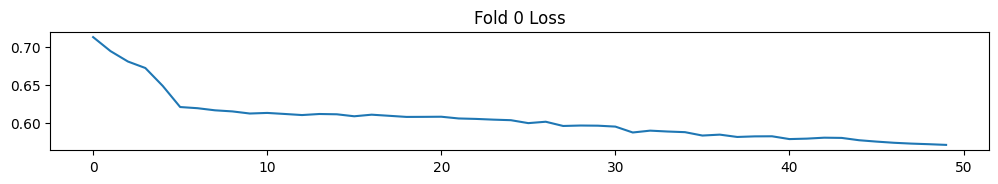

100%|██████████| 50/50 [11:17<00:00, 13.56s/it]


Fold 1 Jaccard: 0.6172 Loss: 0.6821


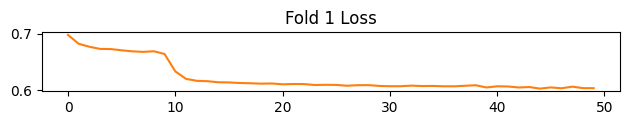

100%|██████████| 50/50 [11:13<00:00, 13.47s/it]


Fold 2 Jaccard: 0.6221 Loss: 0.6693


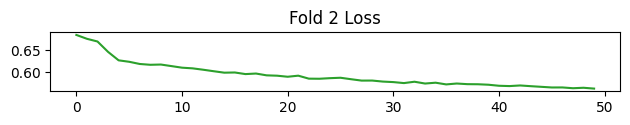

100%|██████████| 50/50 [11:18<00:00, 13.56s/it]


Fold 3 Jaccard: 0.6612 Loss: 0.6711


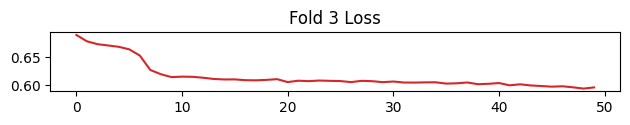

100%|██████████| 50/50 [11:28<00:00, 13.78s/it]


Fold 4 Jaccard: 0.5683 Loss: 0.6603


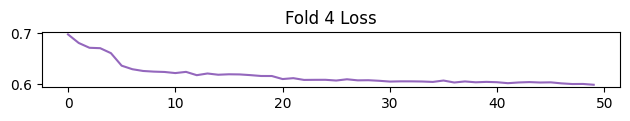

In [ ]:
from sklearn.model_selection import KFold
from torch.utils.data import Subset

K = 5

dataset = CastomDataset(DATASET, aug)

kfold = KFold(n_splits=K, shuffle=True, random_state=42)

plt.figure(figsize=(10, 8))
fold_metrics = []

for i, (train_index, test_index) in enumerate(kfold.split(dataset)):
    train_subset = Subset(dataset, train_index)
    test_subset = Subset(dataset, test_index)

    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_subset, batch_size=32, shuffle=True, num_workers=2)

    net = UNET(3, 16, 1)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(net.parameters(), lr=3e-4)

    net = net.cuda()

    torch.cuda.empty_cache()

    EPOCHS = 50

    loss_results = []

    for epoch in tqdm(range(EPOCHS)):
        val_loss = 0.0

        for _, data in enumerate(train_loader, 0):
            x = data['image']
            y = data['mask']

            optimizer.zero_grad()
            outputs = net(x.cuda().float())

            loss = criterion(outputs, y.cuda().float())
            val_loss += loss.item()
            loss.backward()
            optimizer.step()


        loss_results.append(val_loss / len(train_loader))

    jaccard = jaccard_index(net, test_loader)
    print(f"Fold {i} Jaccard: {jaccard:.4f} Loss: {loss_results[i]:.4f}")
    fold_metrics.append(jaccard)
    
    plt.subplot(K,1,i+1)
    plt.plot(range(EPOCHS), loss_results, color=f'C{i}')

    plt.title(f"Fold {i} Loss")

    plt.tight_layout()
    plt.show()

In [14]:
print(f"Max jaccard: {np.max(fold_metrics)}")
print(f"Mean jaccard: {np.mean(fold_metrics)}")

Max jaccard: 0.622139375237311
Mean jaccard: 0.6127475632451815


# Сравнение

Результаты, полученные при обучении моделей на различных фолдах, соответствуют результатам, полученным при стандартном обучении. Это позволяет заключить, что модель способна предсказывать реальные данные и не переобучилась.